# Feature Engineering

Build customer-level features for Track 1 (Descriptive) and Track 2 (Causal) analyses.

**Track 1 Features (33 base):**
- RFM Features (19+2): Recency, Frequency, Monetary
- Behavioral Features (7): Price sensitivity, brand preference, basket
- Category Features (6): Macro category spending shares
- Time Features (1): Shopping regularity

**Track 2 Features (additional):**
- Exposure (3): Marketing display/mailer exposure
- Campaign (5): Campaign targeting indicators
- Outcome (4): Redemption, purchase outcomes
- Demographic (7): Household demographics

## Table of Contents

1. [Setup & Data Loading](#1.-Setup-&-Data-Loading)
2. [Track 1: Base Features](#2.-Track-1:-Base-Features)
   - 2.1 RFM Features
   - 2.2 Behavioral Features
   - 2.3 Category Features
   - 2.4 Time Features
   - 2.5 Build All Track 1 Features
3. [Track 2: Causal Features](#3.-Track-2:-Causal-Features)
   - 3.1 Marketing Exposure Features
   - 3.2 Campaign Targeting Features
   - 3.3 Outcome Features
   - 3.4 Demographic Features
   - 3.5 Build All Track 2 Features
   - 3.6 Scenario 1: Campaign-specific Features *(NEW)*
4. [Feature Analysis](#4.-Feature-Analysis)
   - 4.1 Missing Values
   - 4.2 Distributions
   - 4.3 Correlations
   - 4.4 Value/Need Groups
5. [Feature Export](#5.-Feature-Export)

---

## 1. Setup & Data Loading

In [1]:
%load_ext autoreload
%autoreload 2

import json
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project paths
PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = PROJECT_PATH.parents[1] / 'data' / 'dunnhumby'
RAW_PATH = DATA_PATH / 'raw'
PROCESSED_PATH = DATA_PATH / 'processed'

# Create processed directory if not exists
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

print('Project path:', PROJECT_PATH)
print('Data path:', DATA_PATH)
print('Processed path:', PROCESSED_PATH)

Project path: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby
Data path: /Users/taehyun/project/side-projects/data/dunnhumby
Processed path: /Users/taehyun/project/side-projects/data/dunnhumby/processed


In [2]:
# Import feature engineering module
from data.dunnhumby.preprocess import load_transactions
from projects.segmentation_dunnhumby.src.features import (
    # Track 1 functions
    build_rfm_features,
    build_behavioral_features,
    build_category_features,
    build_time_features,
    build_all_features,
    build_track1_features,
    # Track 2 functions
    build_exposure_features,
    build_campaign_features,
    build_outcome_features,
    build_demographic_features,
    build_track2_features,
    # Constants
    MACRO_CATEGORY,
    FEATURE_COLS,
    TRACK1_FEATURE_COLS,
    ALL_FEATURE_COLS,
    VALUE_FEATURES,
    NEED_FEATURES,
)
from projects.segmentation_dunnhumby.src.cohorts import (
    define_track1_cohort,
    define_track2_base_cohort,
)

In [3]:
# Load all data
print("Loading data...")

# Transaction data (with preprocessing)
df_trans = load_transactions(RAW_PATH)
print(f"Transactions: {len(df_trans):,} rows")

# Product data
df_product = pd.read_csv(RAW_PATH / 'product.csv')
print(f"Products: {len(df_product):,} rows")

# Campaign data
df_campaign_table = pd.read_csv(RAW_PATH / 'campaign_table.csv')
df_campaign_desc = pd.read_csv(RAW_PATH / 'campaign_desc.csv')
print(f"Campaign targeting: {len(df_campaign_table):,} rows")
print(f"Campaigns: {len(df_campaign_desc)} campaigns")

# Coupon data
df_coupon_redempt = pd.read_csv(RAW_PATH / 'coupon_redempt.csv')
print(f"Coupon redemptions: {len(df_coupon_redempt):,} rows")

# Demographic data
df_demo = pd.read_csv(RAW_PATH / 'hh_demographic.csv')
print(f"Households with demographics: {len(df_demo):,} rows")

# Causal data (large file - may take time)
print("\nLoading causal_data.csv (this may take a while)...")
df_causal = pd.read_csv(RAW_PATH / 'causal_data.csv')
print(f"Causal data: {len(df_causal):,} rows")

Loading data...
Transactions: 2,581,260 rows
Products: 92,353 rows
Campaign targeting: 7,208 rows
Campaigns: 30 campaigns
Coupon redemptions: 2,318 rows
Households with demographics: 801 rows

Loading causal_data.csv (this may take a while)...
Causal data: 36,786,524 rows


In [4]:
# Data summary
print("=" * 50)
print("DATA SUMMARY")
print("=" * 50)
print(f"\nUnique households: {df_trans['household_key'].nunique():,}")
print(f"Date range: Day {df_trans['DAY'].min()} - {df_trans['DAY'].max()}")
print(f"Week range: {df_trans['WEEK_NO'].min()} - {df_trans['WEEK_NO'].max()}")
print(f"\nTrack 1 cohort: {len(define_track1_cohort(df_trans)):,} customers")
print(f"Track 2 cohort: {len(define_track2_base_cohort(df_trans)):,} customers")
print(f"\nDemographics available: {len(df_demo):,} / {df_trans['household_key'].nunique():,} ({len(df_demo)/df_trans['household_key'].nunique()*100:.1f}%)")

DATA SUMMARY

Unique households: 2,500
Date range: Day 1 - 711
Week range: 1 - 102

Track 1 cohort: 2,500 customers
Track 2 cohort: 2,457 customers

Demographics available: 801 / 2,500 (32.0%)


---

## 2. Track 1: Base Features

Build 33 base customer features using full observation period (Week 1-102).

### 2.1 RFM Features

| Group | Count | Features |
|-------|-------|----------|
| **Recency** | 6 | recency, recency_weeks, active_last_4w/12w, days_between_purchases_avg/std |
| **Frequency** | 6 | frequency, frequency_per_week/month, transaction_count, weeks_with_purchase, purchase_regularity |
| **Monetary** | 7 | monetary_sales/actual, avg_basket_sales/actual, monetary_std, monetary_per_week, coupon_savings_ratio |
| *Auxiliary* | 2 | tenure, tenure_weeks |

In [5]:
# Build RFM features
df_rfm = build_rfm_features(df_trans)

print(f"RFM features: {df_rfm.shape[1] - 1} columns (excluding household_key)")
print(f"\nColumns: {list(df_rfm.columns)}")
df_rfm.head()

RFM features: 21 columns (excluding household_key)

Columns: ['household_key', 'recency', 'recency_weeks', 'active_last_4w', 'active_last_12w', 'days_between_purchases_avg', 'days_between_purchases_std', 'frequency', 'frequency_per_week', 'frequency_per_month', 'transaction_count', 'weeks_with_purchase', 'purchase_regularity', 'monetary_sales', 'monetary_actual', 'monetary_avg_basket_sales', 'monetary_avg_basket_actual', 'monetary_std', 'monetary_per_week', 'coupon_savings_ratio', 'tenure', 'tenure_weeks']


,household_key,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,...,purchase_regularity,monetary_sales,monetary_actual,monetary_avg_basket_sales,monetary_avg_basket_actual,monetary_std,monetary_per_week,coupon_savings_ratio,tenure,tenure_weeks
0,1,5,0,1,1,8.506494,4.551647,85,0.894737,3.874211,...,0.715789,4330.16,4256.85,50.943059,50.080588,35.834565,45.580632,0.016930,660,95
1,2,43,6,0,1,12.840909,14.445734,45,0.511364,2.214205,...,0.397727,1954.34,1945.34,43.429778,43.229778,38.151384,22.208409,0.004605,608,88
2,3,8,1,1,1,13.111111,12.438689,47,0.546512,2.366395,...,0.430233,2653.21,2592.02,56.451277,55.149362,62.790677,30.851279,0.023063,598,86
3,4,84,12,0,1,18.034483,17.527285,30,0.344828,1.493103,...,0.298851,1200.11,1197.61,40.003667,39.920333,35.085380,13.794368,0.002083,607,87
4,5,8,1,1,1,19.312500,22.187324,40,0.444444,1.924444,...,0.300000,779.06,779.06,19.476500,19.476500,15.051558,8.656222,0.000000,626,90


### 2.2 Behavioral Features

| Feature | Description |
|---------|-------------|
| discount_rate | Total discount / shelf price ratio |
| discount_usage_pct | % of transactions with discounts |
| private_label_ratio | Private label / total purchases |
| n_departments | Unique departments shopped |
| n_products | Unique products purchased |
| avg_items_per_basket | Average quantity per basket |
| avg_products_per_basket | Average unique products per basket |

In [6]:
# Build behavioral features
df_behavioral = build_behavioral_features(df_trans, df_product)

print(f"Behavioral features: {df_behavioral.shape[1] - 1} columns")
df_behavioral.head()

Behavioral features: 7 columns


,household_key,discount_rate,discount_usage_pct,private_label_ratio,n_departments,n_products,avg_items_per_basket,avg_products_per_basket
0,1,0.151034,0.443860,0.118713,12,674,23.494118,7.929412
1,2,0.149670,0.458626,0.235624,12,545,18.533333,12.111111
2,3,0.217241,0.557003,0.187839,11,515,181.702128,10.957447
3,4,0.089626,0.433333,0.153333,9,164,12.733333,5.466667
4,5,0.131860,0.531532,0.216216,9,199,6.125000,4.975000


### 2.3 Category Features

Macro category spending shares (6 categories):
- grocery, fresh, bakery, health_beauty, alcohol, other

In [7]:
# Build category features
df_category = build_category_features(df_trans, df_product)

print(f"Category features: {df_category.shape[1] - 1} columns")
print(f"\nMacro category mapping:")
for cat, depts in MACRO_CATEGORY.items():
    print(f"  {cat}: {depts[:3]}{'...' if len(depts) > 3 else ''}")
df_category.head()

Category features: 6 columns

Macro category mapping:
  grocery: ['GROCERY', 'FROZEN GROCERY', 'GRO BAKERY']
  fresh: ['PRODUCE', 'MEAT', 'MEAT-PCKGD']...
  bakery: ['PASTRY']
  health_beauty: ['DRUG GM', 'NUTRITION', 'COSMETICS']...
  alcohol: ['SPIRITS']


,household_key,share_alcohol,share_bakery,share_fresh,share_grocery,share_health_beauty,share_other
0,1,0.0,0.022011,0.200563,0.636235,0.133764,0.007427
1,2,0.0,0.012700,0.220637,0.569241,0.183991,0.013432
2,3,0.0,0.001240,0.258114,0.672676,0.060429,0.007542
3,4,0.0,0.000000,0.147478,0.582222,0.270300,0.000000
4,5,0.0,0.003055,0.260558,0.460979,0.275409,0.000000


### 2.4 Time Features

- **week_coverage**: Active weeks / tenure weeks (shopping consistency)

In [8]:
# Build time features
df_time = build_time_features(df_trans)

print(f"Time features: {df_time.shape[1] - 1} columns")
df_time.head()

Time features: 1 columns


,household_key,week_coverage
0,1,0.715789
1,2,0.426829
2,3,0.435294
3,4,0.346667
4,5,0.303371


### 2.5 Build All Track 1 Features

In [9]:
# Build all Track 1 features
df_track1 = build_track1_features(df_trans, df_product)

print(f"Track 1 feature matrix: {df_track1.shape}")
print(f"\nFeature groups:")
for group in ['recency', 'frequency', 'monetary', 'behavioral', 'category', 'time']:
    print(f"  - {group}: {len(FEATURE_COLS[group])} features")
print(f"\nTotal: {len(TRACK1_FEATURE_COLS)} features")

df_track1.head()

Track 1 feature matrix: (2500, 36)

Feature groups:
  - recency: 6 features
  - frequency: 6 features
  - monetary: 7 features
  - behavioral: 7 features
  - category: 6 features
  - time: 1 features

Total: 33 features


,household_key,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,...,n_products,avg_items_per_basket,avg_products_per_basket,share_alcohol,share_bakery,share_fresh,share_grocery,share_health_beauty,share_other,week_coverage
0,1,5,0,1,1,8.506494,4.551647,85,0.894737,3.874211,...,674,23.494118,7.929412,0.0,0.022011,0.200563,0.636235,0.133764,0.007427,0.715789
1,2,43,6,0,1,12.840909,14.445734,45,0.511364,2.214205,...,545,18.533333,12.111111,0.0,0.012700,0.220637,0.569241,0.183991,0.013432,0.426829
2,3,8,1,1,1,13.111111,12.438689,47,0.546512,2.366395,...,515,181.702128,10.957447,0.0,0.001240,0.258114,0.672676,0.060429,0.007542,0.435294
3,4,84,12,0,1,18.034483,17.527285,30,0.344828,1.493103,...,164,12.733333,5.466667,0.0,0.000000,0.147478,0.582222,0.270300,0.000000,0.346667
4,5,8,1,1,1,19.312500,22.187324,40,0.444444,1.924444,...,199,6.125000,4.975000,0.0,0.003055,0.260558,0.460979,0.275409,0.000000,0.303371


---

## 3. Track 2: Causal Features

Build additional features for causal analysis:
- **Confounders**: Pre-treatment base features (Week 1-31) + exposure + demographics
- **Treatment**: Campaign targeting indicators
- **Outcome**: Campaign period (Week 32-102) outcomes

### 3.1 Marketing Exposure Features

From `causal_data.csv` (product-store-week level), aggregate to household level:
- **display_exposure_rate**: Proportion of purchases with display exposure
- **display_intensity_avg**: Mean display level when exposed (1-9/A)
- **mailer_exposure_rate**: Proportion of purchases with mailer exposure

In [10]:
# Build exposure features
print("Building exposure features (joining transaction with causal_data)...")
df_exposure = build_exposure_features(df_trans, df_causal)

print(f"\nExposure features: {df_exposure.shape[1] - 1} columns")
print(f"Households: {len(df_exposure):,}")
df_exposure.describe()

Building exposure features (joining transaction with causal_data)...

Exposure features: 3 columns
Households: 2,500


,household_key,display_exposure_rate,display_intensity_avg,mailer_exposure_rate
count,2500.00000,2500.000000,2500.000000,2500.000000
mean,1250.50000,0.107480,5.127184,0.162824
std,721.83216,0.052250,1.061974,0.074960
min,1.00000,0.000000,0.000000,0.000000
25%,625.75000,0.071429,4.679355,0.115721
50%,1250.50000,0.102437,5.248684,0.151549
75%,1875.25000,0.137957,5.750000,0.197713
max,2500.00000,0.500000,9.000000,0.625490


### 3.2 Campaign Targeting Features

From `campaign_table.csv`:
- **targeted_typeA/B/C**: Binary indicators for each campaign type
- **n_campaigns_targeted**: Total number of campaigns targeted
- **n_typeA_campaigns**: Number of TypeA campaigns targeted

In [11]:
# Build campaign features
df_campaign = build_campaign_features(df_campaign_table, df_campaign_desc)

print(f"Campaign features: {df_campaign.shape[1] - 1} columns")
print(f"Households with any targeting: {len(df_campaign):,}")
print(f"\nTargeting rates:")
print(f"  TypeA: {df_campaign['targeted_typeA'].sum():,} ({df_campaign['targeted_typeA'].mean()*100:.1f}%)")
print(f"  TypeB: {df_campaign['targeted_typeB'].sum():,} ({df_campaign['targeted_typeB'].mean()*100:.1f}%)")
print(f"  TypeC: {df_campaign['targeted_typeC'].sum():,} ({df_campaign['targeted_typeC'].mean()*100:.1f}%)")

df_campaign.head()

Campaign features: 5 columns
Households with any targeting: 1,584

Targeting rates:
  TypeA: 1,513 (95.5%)
  TypeB: 1,023 (64.6%)
  TypeC: 397 (25.1%)


campaign_type,household_key,targeted_typeA,targeted_typeB,targeted_typeC,n_campaigns_targeted,n_typeA_campaigns
0,1,1,1,1,8,3
1,2,1,0,0,1,1
2,3,1,0,1,3,2
3,4,1,0,0,1,1
4,6,1,1,0,4,3


### 3.3 Outcome Features

Campaign period (Week 32-102) outcomes:
- **redemption_count**: Number of coupon redemptions
- **redemption_any**: Binary redemption indicator
- **purchase_amount**: Total purchase amount
- **purchase_count**: Number of baskets

In [12]:
# Build outcome features
df_outcome = build_outcome_features(df_trans, df_coupon_redempt, period_start=32, period_end=102)

print(f"Outcome features: {df_outcome.shape[1] - 1} columns")
print(f"Households in campaign period: {len(df_outcome):,}")
print(f"\nRedemption rate: {df_outcome['redemption_any'].mean()*100:.2f}%")
print(f"Average purchase amount: ${df_outcome['purchase_amount'].mean():,.2f}")

df_outcome.describe()

Outcome features: 4 columns
Households in campaign period: 2,490

Redemption rate: 17.43%
Average purchase amount: $2,506.96


,household_key,redemption_count,redemption_any,purchase_amount,purchase_count
count,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000
mean,1250.424900,0.930924,0.174297,2506.964783,84.116466
std,721.461267,3.237246,0.379441,2693.600184,91.392443
min,1.000000,0.000000,0.000000,6.580000,1.000000
25%,627.250000,0.000000,0.000000,674.322500,27.000000
50%,1249.500000,0.000000,0.000000,1625.740000,58.000000
75%,1874.750000,0.000000,0.000000,3446.712500,110.750000
max,2500.000000,35.000000,1.000000,32587.960000,987.000000


### 3.4 Demographic Features

From `hh_demographic.csv` (801 households only):
- AGE_DESC, MARITAL_STATUS_CODE, INCOME_DESC
- HOMEOWNER_DESC, HH_COMP_DESC, HOUSEHOLD_SIZE_DESC
- KID_CATEGORY_DESC

In [13]:
# Build demographic features
df_demo_features = build_demographic_features(df_demo)

print(f"Demographic features: {df_demo_features.shape[1] - 1} columns")
print(f"Households with demographics: {len(df_demo_features):,}")
print(f"\nColumns: {list(df_demo_features.columns)}")
df_demo_features.head()

Demographic features: 2 columns
Households with demographics: 801

Columns: ['household_key', 'HOMEOWNER_DESC', 'KID_CATEGORY_DESC']


,household_key,HOMEOWNER_DESC,KID_CATEGORY_DESC
0,1,Homeowner,None/Unknown
1,7,Homeowner,None/Unknown
2,8,Unknown,1
3,13,Homeowner,2
4,16,Homeowner,None/Unknown


### 3.5 Build All Track 2 Features

Uses pre-treatment period (Week 1-31) for base features to avoid information leakage.

In [14]:
# Build all Track 2 features
print("Building Track 2 features...")
print("  - Pre-treatment period: Week 1-31")
print("  - Campaign period: Week 32-102")

df_track2 = build_track2_features(
    df_trans=df_trans,
    df_product=df_product,
    df_causal=df_causal,
    df_campaign_table=df_campaign_table,
    df_campaign_desc=df_campaign_desc,
    df_coupon_redempt=df_coupon_redempt,
    df_demo=df_demo,
    pre_period_end=31,
    campaign_period_start=32
)

print(f"\nTrack 2 feature matrix: {df_track2.shape}")
print(f"\nFeature groups:")
for group, cols in FEATURE_COLS.items():
    n_available = sum(1 for c in cols if c in df_track2.columns)
    print(f"  - {group}: {n_available}/{len(cols)} features")

df_track2.head()

Building Track 2 features...
  - Pre-treatment period: Week 1-31
  - Campaign period: Week 32-102

Track 2 feature matrix: (2494, 50)

Feature groups:
  - recency: 6/6 features
  - frequency: 6/6 features
  - monetary: 7/7 features
  - behavioral: 7/7 features
  - category: 6/6 features
  - time: 1/1 features
  - exposure: 3/3 features
  - campaign: 5/5 features
  - outcome: 4/4 features
  - demographic: 2/7 features


,household_key,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,...,targeted_typeB,targeted_typeC,n_campaigns_targeted,n_typeA_campaigns,redemption_count,redemption_any,purchase_amount,purchase_count,HOMEOWNER_DESC,KID_CATEGORY_DESC
0,1,4,0,1,1,10.000000,4.623311,17,0.708333,3.067083,...,1,1,8,3,5.0,1.0,3360.23,68.0,Homeowner,None/Unknown
1,2,7,1,1,1,5.833333,4.681524,19,1.117647,4.839412,...,0,0,1,1,0.0,0.0,1384.25,26.0,NaN,NaN
2,3,9,1,1,1,7.153846,5.668349,14,0.933333,4.041333,...,0,1,3,2,0.0,0.0,1747.53,33.0,NaN,NaN
3,4,16,2,1,1,19.000000,10.751744,6,0.375000,1.623750,...,0,0,1,1,0.0,0.0,731.68,24.0,NaN,NaN
4,5,23,3,1,1,9.727273,6.121362,16,0.842105,3.646316,...,0,0,0,0,0.0,0.0,385.01,24.0,NaN,NaN


In [15]:
# Filter to Track 2 cohort (pre-treatment + campaign period activity)
track2_cohort = define_track2_base_cohort(df_trans)
df_track2_cohort = df_track2[df_track2['household_key'].isin(track2_cohort)].copy()

print(f"Track 2 cohort size: {len(df_track2_cohort):,} customers")
print(f"(Filtered from {len(df_track2):,} total)")

Track 2 cohort size: 2,457 customers
(Filtered from 2,494 total)


### 3.6 Scenario 1: First Campaign Only Features

**Design Rationale:** For clean causal identification, each customer appears exactly once using their **first TypeA campaign** only.

| Item | Definition |
|------|------------|
| **Treatment** | Customer's first TypeA campaign targeting (1,513 customers) |
| **Control** | Never targeted by any TypeA campaign (987 customers) |
| **Total Sample** | 2,500 observations (1 per customer) |

**Why First Campaign Only?**
- **Avoids pre-treatment contamination**: Original design had Campaign 30's pre-treatment (Week 1-46) including Campaign 26's treatment period (Week 32-38)
- **Independent observations**: Each customer appears exactly once
- **Trade-off**: 62% sample reduction (3,979 → 1,513 treatment) but cleaner causal estimates

**First Campaign Distribution:**

| Campaign | Weeks | Treatment | Control |
|----------|-------|-----------|---------|
| 26 | 32-38 | 332 | 987 |
| 30 | 47-53 | 126 | (same) |
| 8 | 59-66 | 768 | (same) |
| 13 | 72-79 | 153 | (same) |
| 18 | 84-92 | 134 | (same) |

Control customers are assigned to their first active campaign period.

In [16]:
# Import Scenario 1 functions
from projects.segmentation_dunnhumby.src.features import (
    get_campaign_periods,
    build_scenario1_features,
)
from projects.segmentation_dunnhumby.src.cohorts import (
    build_scenario1_first_campaign_cohort,
)

# Show campaign periods
campaign_periods = get_campaign_periods(df_campaign_desc, 'TypeA', post_window=4)
print("TypeA Campaign Periods:")
display(campaign_periods)

# Build Scenario 1 features with First Campaign Only (default)
print("\nBuilding Scenario 1 features (First Campaign Only)...")
print("  - Each customer appears exactly once")
print("  - Treatment: Customer's first TypeA campaign targeting")
print("  - Control: Never-targeted, assigned to first active campaign")

df_scenario1 = build_scenario1_features(
    df_trans=df_trans,
    df_product=df_product,
    df_causal=df_causal,
    df_campaign_table=df_campaign_table,
    df_campaign_desc=df_campaign_desc,
    df_coupon_redempt=df_coupon_redempt,
    df_demo=df_demo,
    post_window=4,
    first_campaign_only=True  # Default, explicit for clarity
)

print(f"\nScenario 1 feature matrix: {df_scenario1.shape}")
print(f"  - Observations: {len(df_scenario1):,} (1 per customer)")
print(f"  - Unique customers: {df_scenario1['household_key'].nunique():,}")
print(f"  - Treatment: {df_scenario1['targeted'].sum():,}")
print(f"  - Control: {(df_scenario1['targeted'] == 0).sum():,}")

print(f"\nFirst campaign distribution (Treatment only):")
treatment_dist = (
    df_scenario1[df_scenario1['targeted'] == 1]
    .groupby('CAMPAIGN')
    .size()
    .reset_index(name='count')
    .merge(campaign_periods[['CAMPAIGN', 'start_week', 'end_week']], on='CAMPAIGN')
)
display(treatment_dist)

df_scenario1.head()

TypeA Campaign Periods:


,CAMPAIGN,campaign_type,start_week,end_week,pre_end_week,outcome_start_week,outcome_end_week
0,26,TypeA,32,38,31,32,42
1,30,TypeA,47,53,46,47,57
2,8,TypeA,59,66,58,59,70
3,13,TypeA,72,79,71,72,83
4,18,TypeA,84,92,83,84,96



Building Scenario 1 features (First Campaign Only)...
  - Each customer appears exactly once
  - Treatment: Customer's first TypeA campaign targeting
  - Control: Never-targeted, assigned to first active campaign

Scenario 1 feature matrix: (2430, 53)
  - Observations: 2,430 (1 per customer)
  - Unique customers: 2,430
  - Treatment: 1,511
  - Control: 919

First campaign distribution (Treatment only):


,CAMPAIGN,count,start_week,end_week
0,8,768,59,66
1,13,153,72,79
2,18,132,84,92
3,26,332,32,38
4,30,126,47,53


,household_key,CAMPAIGN,targeted,campaign_type,start_week,end_week,pre_end_week,outcome_start_week,outcome_end_week,recency,...,week_coverage,display_exposure_rate,display_intensity_avg,mailer_exposure_rate,redemption_count,redemption_any,purchase_amount,purchase_count,HOMEOWNER_DESC,KID_CATEGORY_DESC
0,1,8,1,TypeA,59,66,58,59,70,4,...,0.686275,0.094857,4.746988,0.113143,3.0,1.0,636.01,12.0,Homeowner,None/Unknown
1,2,18,1,TypeA,84,92,83,84,96,1,...,0.420290,0.090074,5.326531,0.115809,0.0,0.0,417.34,7.0,NaN,NaN
2,3,8,1,TypeA,59,66,58,59,70,10,...,0.560976,0.221083,5.172185,0.238653,0.0,0.0,302.60,8.0,NaN,NaN
3,4,8,1,TypeA,59,66,58,59,70,26,...,0.475000,0.071713,5.000000,0.067729,0.0,0.0,44.50,2.0,NaN,NaN
4,6,8,1,TypeA,59,66,58,59,70,0,...,1.000000,0.094429,4.720000,0.139754,0.0,0.0,735.15,35.0,NaN,NaN


---

## 4. Feature Analysis

### 4.1 Missing Values

In [17]:
# Track 1 missing values
print("Track 1 Missing Values:")
missing_t1 = df_track1[TRACK1_FEATURE_COLS].isnull().sum()
missing_t1 = missing_t1[missing_t1 > 0]
if len(missing_t1) > 0:
    print(missing_t1)
else:
    print("  No missing values")

# Check for infinities
inf_t1 = np.isinf(df_track1[TRACK1_FEATURE_COLS].select_dtypes(include=[np.number])).sum()
inf_t1 = inf_t1[inf_t1 > 0]
if len(inf_t1) > 0:
    print("\nInfinite values:")
    print(inf_t1)
else:
    print("\nNo infinite values")

Track 1 Missing Values:
days_between_purchases_avg    3
days_between_purchases_std    3
monetary_std                  3
dtype: int64

No infinite values


In [18]:
# Track 2 missing values
print("Track 2 Missing Values (numeric columns):")
numeric_cols = df_track2_cohort.select_dtypes(include=[np.number]).columns
missing_t2 = df_track2_cohort[numeric_cols].isnull().sum()
missing_t2 = missing_t2[missing_t2 > 0]
if len(missing_t2) > 0:
    for col, count in missing_t2.items():
        pct = count / len(df_track2_cohort) * 100
        print(f"  {col}: {count:,} ({pct:.1f}%)")
else:
    print("  No missing values in numeric columns")

print("\nTrack 2 Missing Values (demographic columns):")
demo_cols = [c for c in FEATURE_COLS['demographic'] if c in df_track2_cohort.columns]
if demo_cols:
    missing_demo = df_track2_cohort[demo_cols].isnull().sum()
    for col, count in missing_demo.items():
        pct = count / len(df_track2_cohort) * 100
        print(f"  {col}: {count:,} ({pct:.1f}%)")

Track 2 Missing Values (numeric columns):
  days_between_purchases_avg: 59 (2.4%)
  days_between_purchases_std: 59 (2.4%)
  monetary_std: 52 (2.1%)

Track 2 Missing Values (demographic columns):
  HOMEOWNER_DESC: 1,658 (67.5%)
  KID_CATEGORY_DESC: 1,658 (67.5%)


### 4.2 Distributions

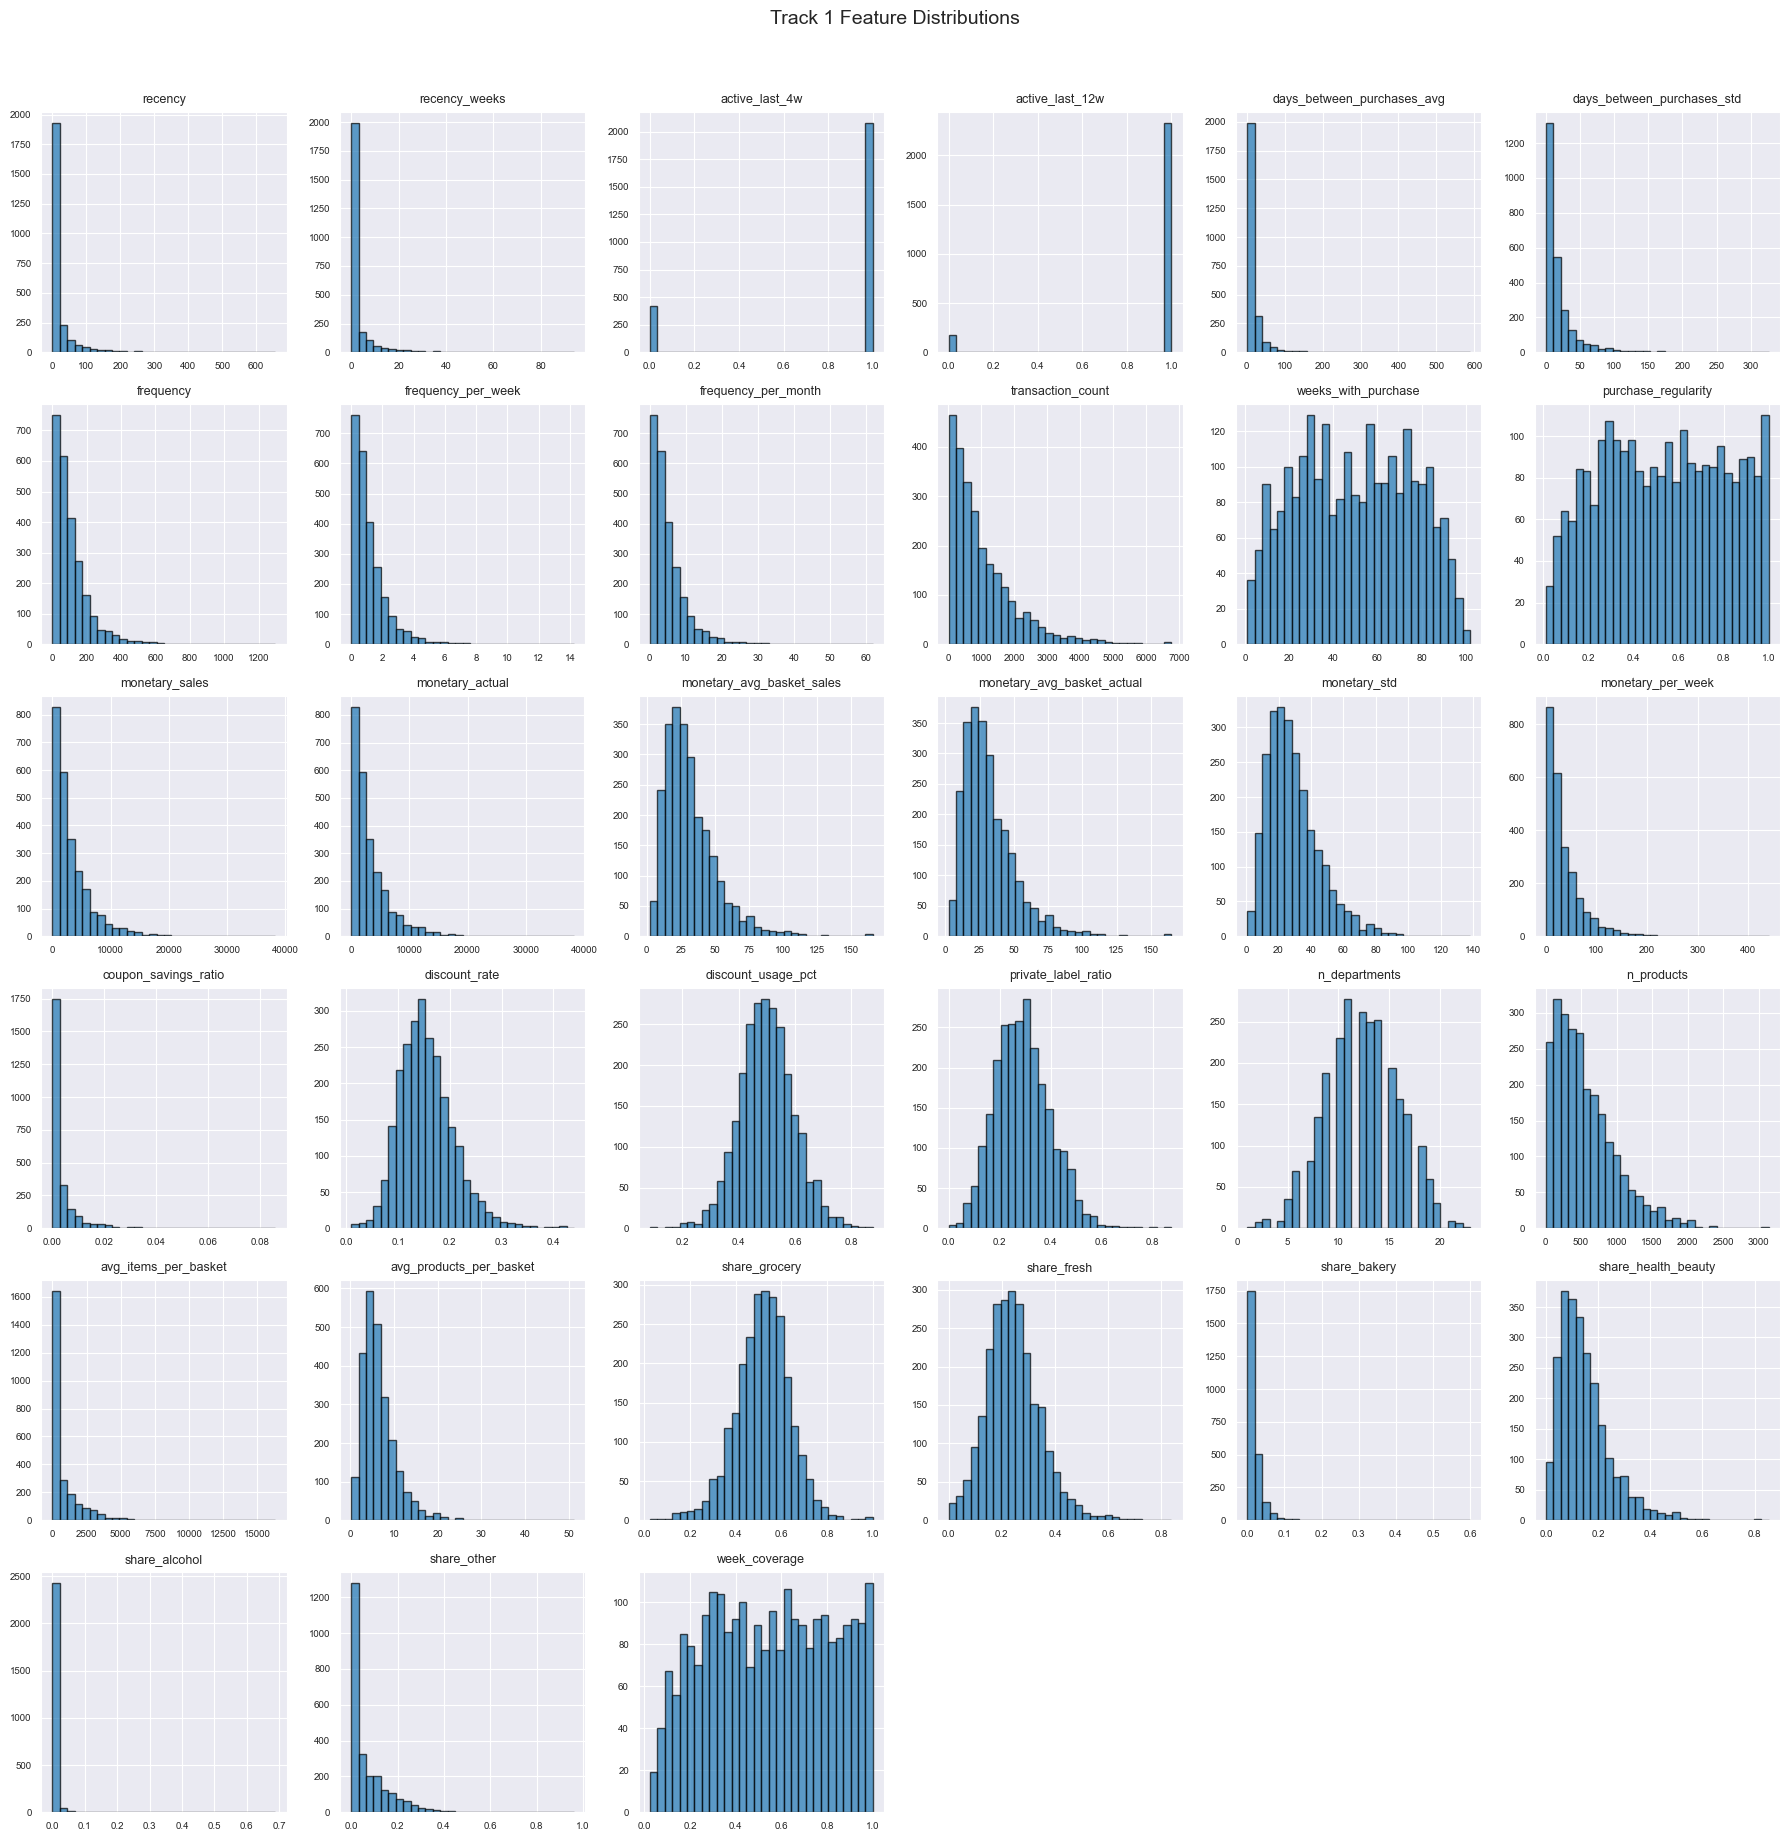

In [19]:
# Track 1 feature distributions
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(TRACK1_FEATURE_COLS):
    if i >= len(axes):
        break
    ax = axes[i]
    data = df_track1[col].dropna()
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=9)
    ax.tick_params(labelsize=7)

# Hide empty subplots
for j in range(len(TRACK1_FEATURE_COLS), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Track 1 Feature Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 4.3 Correlations

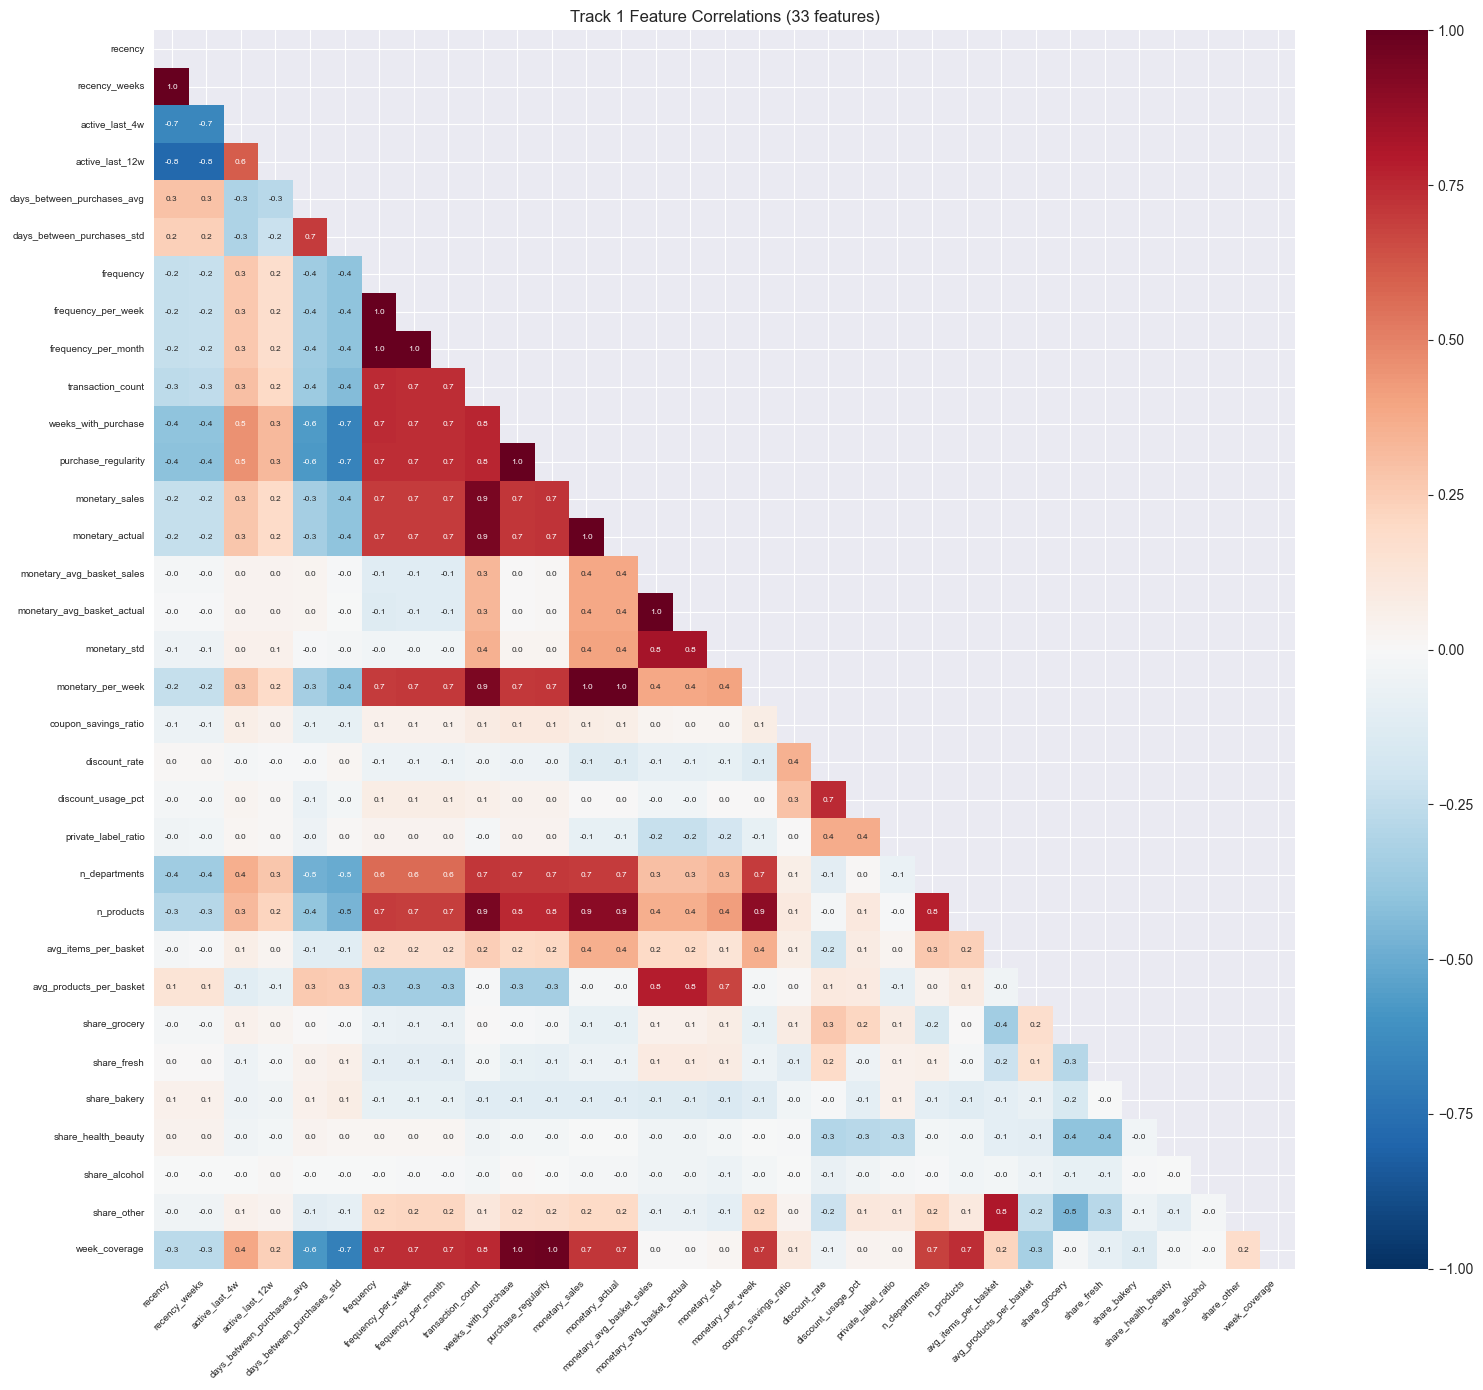

In [20]:
# Track 1 correlation heatmap
fig, ax = plt.subplots(figsize=(16, 14))
corr = df_track1[TRACK1_FEATURE_COLS].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
            annot_kws={'size': 6}, ax=ax, vmin=-1, vmax=1)
ax.set_title(f'Track 1 Feature Correlations ({len(TRACK1_FEATURE_COLS)} features)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

In [21]:
# Identify highly correlated feature pairs
threshold = 0.7
high_corr = []

for i, col1 in enumerate(TRACK1_FEATURE_COLS):
    for col2 in TRACK1_FEATURE_COLS[i+1:]:
        c = corr.loc[col1, col2]
        if abs(c) >= threshold:
            high_corr.append((col1, col2, c))

print(f"Highly correlated pairs (|r| >= {threshold}):")
for col1, col2, c in sorted(high_corr, key=lambda x: -abs(x[2])):
    print(f"  {col1} <-> {col2}: {c:.2f}")

Highly correlated pairs (|r| >= 0.7):
  frequency_per_week <-> frequency_per_month: 1.00
  monetary_sales <-> monetary_actual: 1.00
  monetary_avg_basket_sales <-> monetary_avg_basket_actual: 1.00
  recency <-> recency_weeks: 1.00
  frequency <-> frequency_per_month: 1.00
  frequency <-> frequency_per_week: 1.00
  monetary_sales <-> monetary_per_week: 1.00
  monetary_actual <-> monetary_per_week: 1.00
  weeks_with_purchase <-> purchase_regularity: 0.99
  purchase_regularity <-> week_coverage: 0.98
  weeks_with_purchase <-> week_coverage: 0.98
  transaction_count <-> n_products: 0.95
  transaction_count <-> monetary_sales: 0.95
  transaction_count <-> monetary_actual: 0.95
  transaction_count <-> monetary_per_week: 0.94
  monetary_sales <-> n_products: 0.90
  monetary_actual <-> n_products: 0.90
  monetary_per_week <-> n_products: 0.89
  monetary_avg_basket_sales <-> monetary_std: 0.83
  monetary_avg_basket_actual <-> monetary_std: 0.83
  avg_items_per_basket <-> share_other: 0.81
  mon

### 4.4 Value/Need Groups

For Track 1.2 (CLV x Behavior segmentation):
- **Value Layer**: RFM + Time features (customer value)
- **Need Layer**: Behavioral + Category features (customer needs)

In [22]:
# Value/Need feature separation
print("VALUE FEATURES (RFM + Time):")
print(f"  Count: {len(VALUE_FEATURES)}")
for i, col in enumerate(VALUE_FEATURES):
    print(f"  {i+1}. {col}")

print(f"\nNEED FEATURES (Behavioral + Category):")
print(f"  Count: {len(NEED_FEATURES)}")
for i, col in enumerate(NEED_FEATURES):
    print(f"  {i+1}. {col}")

VALUE FEATURES (RFM + Time):
  Count: 20
  1. recency
  2. recency_weeks
  3. active_last_4w
  4. active_last_12w
  5. days_between_purchases_avg
  6. days_between_purchases_std
  7. frequency
  8. frequency_per_week
  9. frequency_per_month
  10. transaction_count
  11. weeks_with_purchase
  12. purchase_regularity
  13. monetary_sales
  14. monetary_actual
  15. monetary_avg_basket_sales
  16. monetary_avg_basket_actual
  17. monetary_std
  18. monetary_per_week
  19. coupon_savings_ratio
  20. week_coverage

NEED FEATURES (Behavioral + Category):
  Count: 13
  1. discount_rate
  2. discount_usage_pct
  3. private_label_ratio
  4. n_departments
  5. n_products
  6. avg_items_per_basket
  7. avg_products_per_basket
  8. share_grocery
  9. share_fresh
  10. share_bakery
  11. share_health_beauty
  12. share_alcohol
  13. share_other


In [23]:
# Value/Need group statistics
print("Value Features Summary:")
display(df_track1[VALUE_FEATURES].describe().T)

print("\nNeed Features Summary:")
display(df_track1[NEED_FEATURES].describe().T)

Value Features Summary:


,count,mean,std,min,25%,50%,75%,max
recency,2500.0,25.576000,62.791673,0.000000,1.000000,6.000000,20.000000,657.000000
recency_weeks,2500.0,3.419200,8.957386,0.000000,0.000000,1.000000,3.000000,94.000000
active_last_4w,2500.0,0.830800,0.375003,0.000000,1.000000,1.000000,1.000000,1.000000
active_last_12w,2500.0,0.930400,0.254523,0.000000,1.000000,1.000000,1.000000,1.000000
days_between_purchases_avg,2497.0,17.092829,28.245902,1.248077,5.214286,9.176471,18.212121,589.000000
days_between_purchases_std,2497.0,19.385347,27.564067,0.000000,4.735325,9.893022,22.386901,326.500000
frequency,2500.0,110.355600,115.433111,1.000000,38.000000,78.000000,142.000000,1298.000000
frequency_per_week,2500.0,1.188409,1.245894,0.010870,0.411765,0.834249,1.527345,14.263736
frequency_per_month,2500.0,5.145809,5.394721,0.047065,1.782941,3.612299,6.613405,61.761978
transaction_count,2500.0,1032.504000,993.279847,4.000000,321.000000,730.000000,1445.500000,6775.000000



Need Features Summary:


,count,mean,std,min,25%,50%,75%,max
discount_rate,2500.0,0.155242,0.053106,0.009787,0.119097,0.150058,0.184881,0.440070
discount_usage_pct,2500.0,0.499299,0.097042,0.085714,0.436608,0.498277,0.559912,0.875912
private_label_ratio,2500.0,0.290202,0.107814,0.000000,0.214009,0.281876,0.357914,0.873737
n_departments,2500.0,12.358000,3.583151,1.000000,10.000000,12.000000,15.000000,23.000000
n_products,2500.0,558.067600,434.335856,4.000000,230.000000,453.000000,784.000000,3144.000000
avg_items_per_basket,2500.0,728.001253,1241.327026,1.593750,13.527193,137.506603,965.912690,16322.500000
avg_products_per_basket,2500.0,6.502003,3.974498,0.227545,3.864408,5.621966,8.177667,51.200000
share_grocery,2500.0,0.517840,0.118811,0.024805,0.445346,0.524155,0.593156,1.000000
share_fresh,2500.0,0.242617,0.102666,0.000000,0.173703,0.234742,0.299906,0.838235
share_bakery,2500.0,0.018663,0.028790,0.000000,0.004884,0.012138,0.023160,0.600095


---

## 5. Feature Export

Save feature matrices to `data/dunnhumby/processed/`.

In [24]:
# Helper function to prepare DataFrame for parquet export
def prepare_for_parquet(df):
    """Convert object columns to string type for PyArrow compatibility."""
    df = df.copy()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('string')
    return df

# Handle missing values before export
# Track 1: Fill NaN with 0 for interval-based features
df_track1_export = df_track1.copy()
fill_cols = ['days_between_purchases_avg', 'days_between_purchases_std', 'monetary_std']
for col in fill_cols:
    if col in df_track1_export.columns:
        df_track1_export[col] = df_track1_export[col].fillna(0)

# Track 2: Same treatment
df_track2_export = df_track2_cohort.copy()
for col in fill_cols:
    if col in df_track2_export.columns:
        df_track2_export[col] = df_track2_export[col].fillna(0)

# Convert object columns to string for parquet compatibility
df_track1_export = prepare_for_parquet(df_track1_export)
df_track2_export = prepare_for_parquet(df_track2_export)

print("Missing values filled:")
print(f"  Track 1: {fill_cols}")
print(f"  Track 2: {fill_cols} (demographics left as NaN for separate analysis)")
print("\nObject columns converted to string type for parquet compatibility.")

Missing values filled:
  Track 1: ['days_between_purchases_avg', 'days_between_purchases_std', 'monetary_std']
  Track 2: ['days_between_purchases_avg', 'days_between_purchases_std', 'monetary_std'] (demographics left as NaN for separate analysis)

Object columns converted to string type for parquet compatibility.


In [25]:
# Export Track 1 features
df_track1_export.to_parquet(PROCESSED_PATH / 'features_track1.parquet', index=False)
print(f"Saved: features_track1.parquet ({df_track1_export.shape})")

# Export Track 2 features
df_track2_export.to_parquet(PROCESSED_PATH / 'features_track2.parquet', index=False)
print(f"Saved: features_track2.parquet ({df_track2_export.shape})")

# Export Value/Need features (for Track 1.2)
df_value = df_track1_export[['household_key'] + VALUE_FEATURES].copy()
df_value.to_parquet(PROCESSED_PATH / 'features_value.parquet', index=False)
print(f"Saved: features_value.parquet ({df_value.shape})")

df_need = df_track1_export[['household_key'] + NEED_FEATURES].copy()
df_need.to_parquet(PROCESSED_PATH / 'features_need.parquet', index=False)
print(f"Saved: features_need.parquet ({df_need.shape})")

# Export Scenario 1 features (campaign-specific)
if 'df_scenario1' in dir():
    df_scenario1_export = prepare_for_parquet(df_scenario1.copy())
    # Fill NaN for numeric columns
    for col in fill_cols:
        if col in df_scenario1_export.columns:
            df_scenario1_export[col] = df_scenario1_export[col].fillna(0)
    df_scenario1_export.to_parquet(PROCESSED_PATH / 'features_scenario1.parquet', index=False)
    print(f"Saved: features_scenario1.parquet ({df_scenario1_export.shape})")

Saved: features_track1.parquet ((2500, 36))
Saved: features_track2.parquet ((2457, 50))
Saved: features_value.parquet ((2500, 21))
Saved: features_need.parquet ((2500, 14))
Saved: features_scenario1.parquet ((2430, 53))


In [26]:
# Save metadata
metadata = {
    'created_at': datetime.now().isoformat(),
    'files': {
        'features_track1.parquet': {
            'rows': len(df_track1_export),
            'columns': list(df_track1_export.columns),
            'period': 'Week 1-102 (full)',
        },
        'features_track2.parquet': {
            'rows': len(df_track2_export),
            'columns': list(df_track2_export.columns),
            'base_features_period': 'Week 1-31 (pre-treatment)',
            'outcome_period': 'Week 32-102 (campaign)',
        },
        'features_value.parquet': {
            'rows': len(df_value),
            'columns': VALUE_FEATURES,
        },
        'features_need.parquet': {
            'rows': len(df_need),
            'columns': NEED_FEATURES,
        },
    },
    'feature_groups': {k: v for k, v in FEATURE_COLS.items()},
}

with open(PROCESSED_PATH / 'feature_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved: feature_metadata.json")

Saved: feature_metadata.json


In [27]:
# Final summary
print("=" * 60)
print("FEATURE EXPORT SUMMARY")
print("=" * 60)
print(f"\nOutput directory: {PROCESSED_PATH}")
print(f"\nFiles created:")
for f in sorted(PROCESSED_PATH.glob('*')):
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name}: {size_kb:.1f} KB")

FEATURE EXPORT SUMMARY

Output directory: /Users/taehyun/project/side-projects/data/dunnhumby/processed

Files created:
  .gitkeep: 0.0 KB
  feature_metadata.json: 5.4 KB
  features_need.parquet: 255.0 KB
  features_scenario1.parquet: 555.0 KB
  features_track1.parquet: 533.2 KB
  features_track2.parquet: 501.2 KB
  features_value.parquet: 287.1 KB
